# Kernel Selection for Cosmological Parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import *
from sklearn.gaussian_process.kernels import ConstantKernel as C

In [2]:
np.random.seed(1)

## What is a Kernel?
A kernel (or covariance function) describes the covariance of the Gaussian process random variables. Together with the mean function the kernel completely defines a Gaussian process.
$$
GP(m(x),k(x,x'))
$$
In order to be a valid kernel function the resulting kernel matrix $\sum=k(X,X)$ should be positive definite . Which implies that the matrix should be symmetric . Being positive definite also means that the kernel matrix is invertible .

The process of defining a new valid kernel from scratch is not always trivial. Typically pre-defined kernels are used to model a variety of processes.

## $\chi^{2}$ Method
The objective function $\chi^{2}$ is the total squared error, scaled by the uncertainties. Conceptually, $\chi^{2}$ is like a metric distance in the data space and the best fit model is such that minimizes the value of this function, defined as follows:
$$
\chi^{2}=\sum_{i=1}^{N}{\frac{[y_{i}-f(x_{i})]^{2}}{\sigma_{y_{i}}^{2}}}
$$
where $(x_{i},y_{i})$ are the values of the data points, $\sigma_{y_{i}}^{2}$ are their variances and $f(x_{i})$ are the values of the model evaluated at the independent variable of the data points.

In [3]:
## Function that returns the value of chi^2 for a data array,
## with standard deviations std and model f

def chi2(y,f,std):
    return(sum([((y[i]-f[i])**2)/(std[i]**2) for i in range(len(y))]))

## Several Kernels Tests for Hubble Parameter

In [4]:
# Reading and treatment of the data
data=pd.read_table("Hz_all.dat",sep="\s+")
data_arr=np.asarray(data)

X=np.atleast_2d(np.array([float(i) for i in data_arr[1:,0]])).T
y=np.array([float(i) for i in data_arr[1:,1]])
dy=np.array([float(i) for i in data_arr[1:,2]])

# Values where the predictions will be done
x = np.atleast_2d(np.linspace(0, 2., 1000)).T

In [5]:
# Fuction for graphing
def graphHP(f,sigma):
    plt.figure()

    plt.scatter(X,y,color="black",s=12,label=u'Data')
    plt.errorbar(X.ravel(), y, dy,linestyle="None", elinewidth=1,
            color="black")
    plt.plot(x, y_pred, label=u'Prediction', color='black')
    plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.96*sigma,
                        (y_pred + 1.96*sigma)[::-1]]), color="blueviolet",
         alpha=.35, ec='None', label='$1\sigma$'
        )
    plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 2.576 * sigma,
                        (y_pred + 2.576 * sigma)[::-1]]), color="blue",
         alpha=.15, ec='None', label='$2\sigma$'
        )
    plt.xlabel('$z$')
    plt.ylabel('$H(z)$')
    plt.xlim(0,2)
    plt.legend(loc='upper left')
    plt.grid();

### 1) RBF:
$$
k(x,x')=\exp{\left(-\frac{d(x,x')^{2}}{2\sigma^{2}}\right)}
$$
https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html

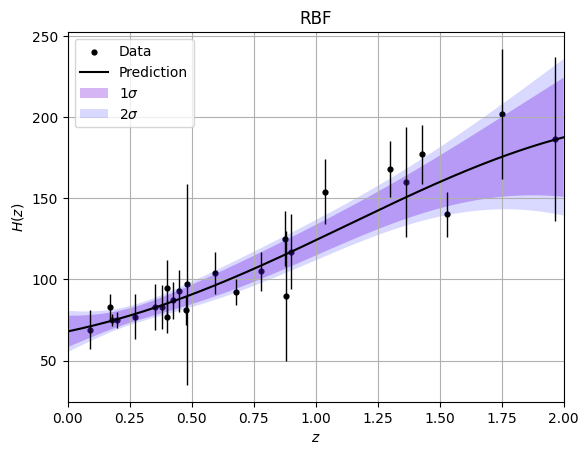

In [6]:
# Model estimation with RBF
k =  C(1.0) * RBF(1, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=k,alpha=dy ** 2,n_restarts_optimizer=10)

gp.fit(X, y)

y_pred, sigma = gp.predict(x, return_std=True)

# chi_2 values produced by the model created with RBF
f,std=gp.predict(X,return_std=True)
H_RBF=chi2(y,f,std)

# Graph
graphHP(y_pred,sigma)
plt.title("RBF")
plt.savefig("HubbleRBF");

### 2) Matern:
$$
k(x,x')=\frac{1}{\Gamma(\nu)2^{\nu-1}}\left(\frac{\sqrt{2\nu}}{l}d(x,x')\right)^{\nu}K^{\nu}\left(\frac{\sqrt{2\nu}}{l}d(x,x')\right)
$$
https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.Matern.html

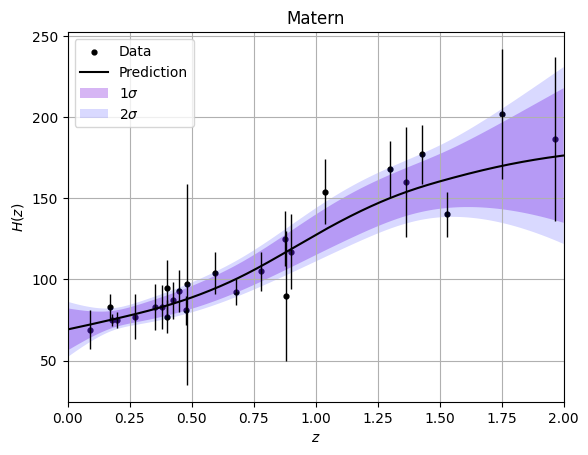

In [7]:
# Model estimation with Matern
k =  C(1.0) * Matern(1, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=k,alpha=dy ** 2,n_restarts_optimizer=10)

gp.fit(X, y)

y_pred, sigma = gp.predict(x, return_std=True)

# chi_2 values produced by the model created with Matern
f,std=gp.predict(X,return_std=True)
H_M=chi2(y,f,std)

# Graph
graphHP(y_pred,sigma)
plt.title("Matern")
plt.savefig("HubbleMatern");

### 3) Exp-Sine-Squared (periodic kernel):
$$
k(x,x')=\exp{\left(-\frac{2\sin^{2}{(\pi d(x,x')/p)}}{l^{2}}\right)}
$$
https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.ExpSineSquared.html

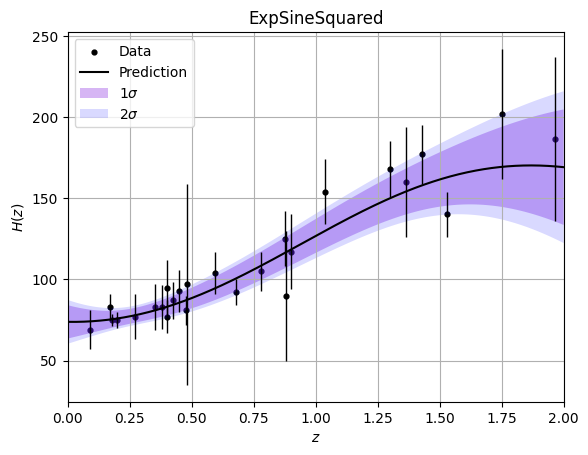

In [8]:
# Model estimation with ESS
k =  C(1.0) * ExpSineSquared()
gp = GaussianProcessRegressor(kernel=k,alpha=dy ** 2,n_restarts_optimizer=10)

gp.fit(X, y)

y_pred, sigma = gp.predict(x, return_std=True)

# chi_2 values produced by the model created with ESS
f,std=gp.predict(X,return_std=True)
H_ESS=chi2(y,f,std)

# Graph
graphHP(y_pred,sigma)
plt.title("ExpSineSquared")
plt.savefig("HubbleESS");

### 4) Dot-Product:
$$
k(x,x')=\sigma_{0}^{2}+x\cdot x'
$$
https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.DotProduct.html

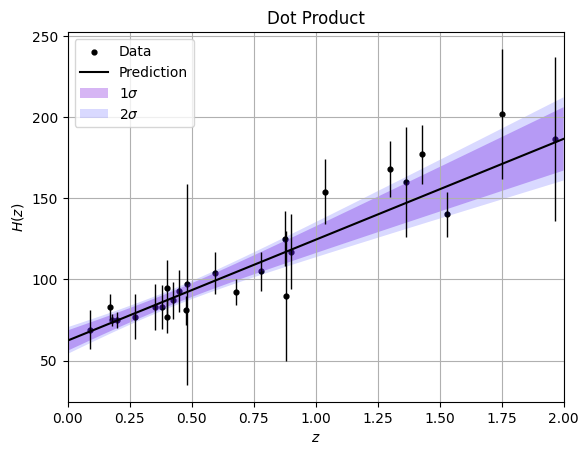

In [9]:
# Model estimation with DP
k =  C(1.0) * DotProduct(1, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=k,alpha=dy ** 2,n_restarts_optimizer=10)

gp.fit(X, y)

y_pred, sigma = gp.predict(x, return_std=True)

# chi_2 values produced by the model created with DP
f,std=gp.predict(X,return_std=True)
H_DP=chi2(y,f,std)

# Graph
graphHP(y_pred,sigma)
plt.title("Dot Product")
plt.savefig("HubbleDP");

### 5) Rational Quadratic
$$
k(x,x')=\left(1+\frac{d(x,x')^{2}}{2\alpha l^{2}}\right)^{-\alpha}
$$
https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RationalQuadratic.html

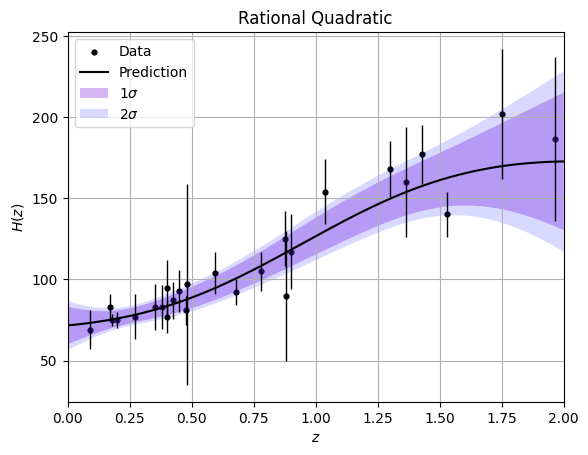

In [10]:
# Model estimation with RQ
k =  C(1.0) * RationalQuadratic()
gp = GaussianProcessRegressor(kernel=k,alpha=dy ** 2,n_restarts_optimizer=10)

gp.fit(X, y)

y_pred, sigma = gp.predict(x, return_std=True)

# chi_2 values produced by the model created with RQ
f,s=gp.predict(X,return_std=True)
H_RQ=chi2(y,f,s)

# Graph
graphHP(y_pred,sigma)
plt.title("Rational Quadratic")
plt.savefig("HubbleRQ");

## Several Kernels Tests for Dark Energy and Comparisons with $\Lambda CDM$ model

In [11]:
# Reading and treatment of the data
data=pd.read_table('star.txt',sep='\s+')

z=np.atleast_2d(np.asarray(data)[:,0]).T
w=np.asarray(data)[:,1]
std=np.asarray(data)[:,2]

# Values where the predictions will be evaluated
zs = np.atleast_2d(np.linspace(0, 3, 1000)).T

In [12]:
def graphDE(f,sigma):
    plt.figure()

    plt.scatter(z,w,color="midnightblue",s=12,label=u'Data')
    plt.errorbar(z.ravel(), w, std,linestyle="None", elinewidth=1, color="black")
    plt.plot(zs, w_pred, color="black", label=u'Predictions')
    plt.fill(np.concatenate([zs, zs[::-1]]),
         np.concatenate([w_pred - 1.96*sigma,
                        (w_pred + 1.96*sigma)[::-1]]),
         alpha=.35, color="blueviolet", ec='None', label='$1\sigma$')
    plt.fill(np.concatenate([zs, zs[::-1]]),
         np.concatenate([w_pred - 2.576 * sigma,
                        (w_pred + 2.576 * sigma)[::-1]]),
         alpha=.15, color="blue", ec='None',label='$2\sigma$')
    plt.xlabel('$z$')
    plt.ylabel('$w(z)$')

    xs=np.linspace(0,3.0,10)
    ys=-np.ones(10)
    plt.plot(xs,ys,label="$\Lambda$CDM",color='red')
    plt.xlim(0,2)
    plt.grid()
    
    plt.legend(loc='lower left');

### 1) RBF

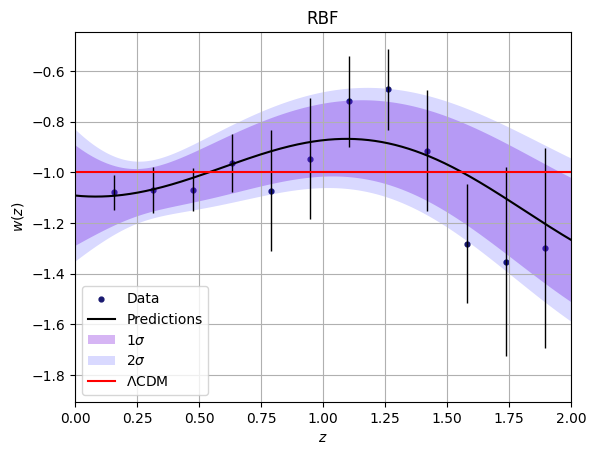

In [13]:
# Model estimation with RBF
k = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=k, alpha=std** 2, n_restarts_optimizer=10)

gp.fit(z, w)

w_pred, sigma = gp.predict(zs, return_std=True)

# chi_2 values produced by the model created with RQ
f,s=gp.predict(z,return_std=True)
DE_RBF=chi2(w,f,s)

# Graph
graphDE(w_pred,sigma)
plt.title("RBF")
plt.savefig("DE_RBF");

### 2) Matern

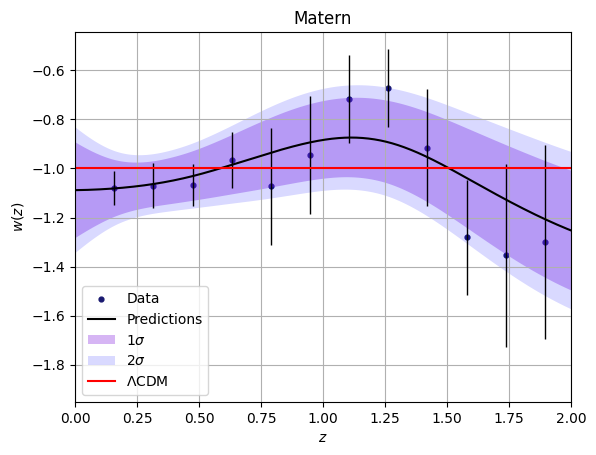

In [14]:
# Model estimation with Matern
k = C(1.0, (1e-3, 1e3)) * Matern(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=k, alpha=std** 2, n_restarts_optimizer=10)

gp.fit(z, w)

w_pred, sigma = gp.predict(zs, return_std=True)

# chi_2 values produced by the model created with Matern
f,s=gp.predict(z,return_std=True)
DE_M=chi2(w,f,s)

# Graph
graphDE(w_pred,sigma)
plt.title("Matern")
plt.savefig("DE_M");

### 3) Exp-Sine-Squared (periodic kernel):

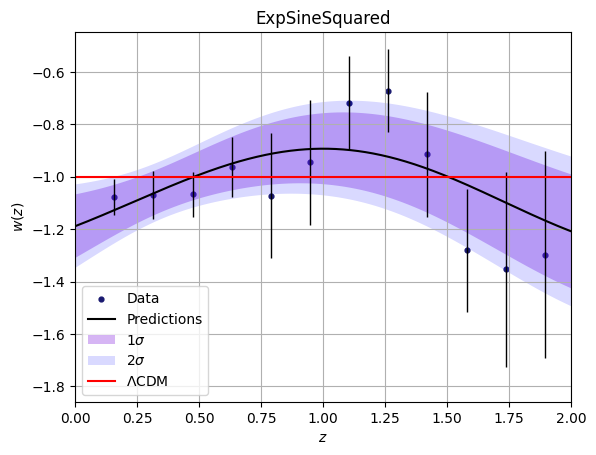

In [15]:
# Model estimation with ESS
k = C(1.1, (1e-3, 1e3)) * ExpSineSquared()
gp = GaussianProcessRegressor(kernel=k, alpha=std** 2, n_restarts_optimizer=10)

gp.fit(z, w)

w_pred, sigma = gp.predict(zs, return_std=True)

# chi_2 values produced by the model created with Matern
f,s=gp.predict(z,return_std=True)
DE_ESS=chi2(w,f,s)

# Graph
graphDE(w_pred,sigma)
plt.title("ExpSineSquared")
plt.savefig("DE_ESS");

### 4) Dot Product

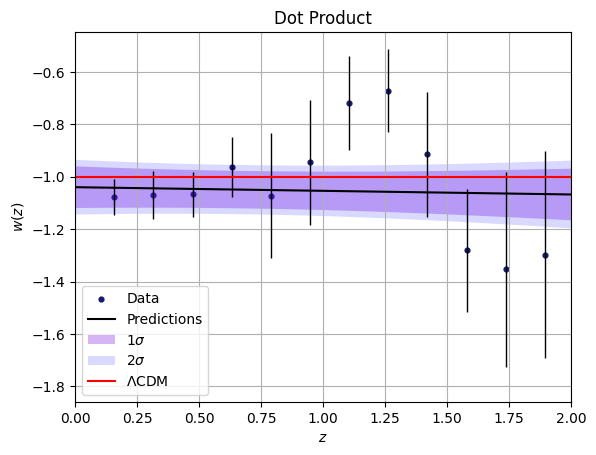

In [16]:
# Model estimation with DP
k = C(1.0, (1e-4, 1e5)) * DotProduct(10, (1e-5, 1e2))
gp = GaussianProcessRegressor(kernel=k, alpha=std** 2, n_restarts_optimizer=10)

gp.fit(z, w)

w_pred, sigma = gp.predict(zs, return_std=True)

# chi_2 values produced by the model created with DP
f,s=gp.predict(z,return_std=True)
DE_DP=chi2(w,f,s)

# Graph
graphDE(w_pred,sigma)
plt.title("Dot Product")
plt.savefig("DE_DP");

### 5) Rational Quadratic

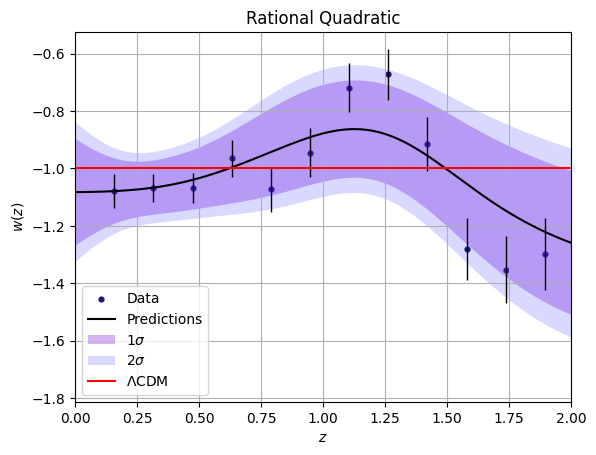

In [17]:
# Model estimation with RQ
k = C(1.0, (1e-3, 1e3)) * RationalQuadratic()
gp = GaussianProcessRegressor(kernel=k, alpha=std** 2, n_restarts_optimizer=10)

gp.fit(z, w)

w_pred, sigma = gp.predict(zs, return_std=True)

# chi_2 values produced by the model created with RQ
f,std=gp.predict(z,return_std=True)
DE_RQ=chi2(w,f,s)

# Graph
graphDE(w_pred,sigma)
plt.title("Rational Quadratic")
plt.savefig("DE_RQ");

## $\chi^{2}$ by kernel

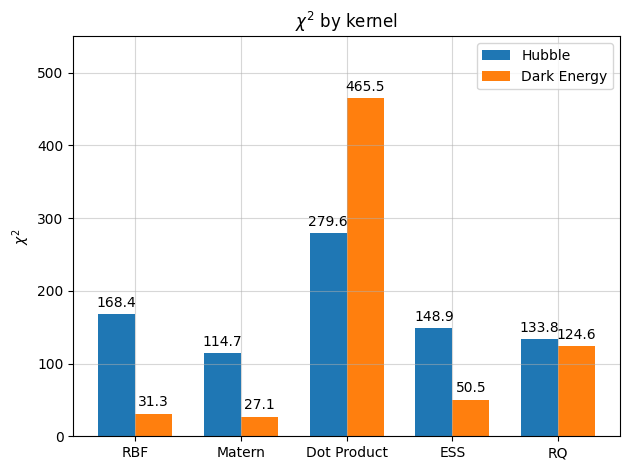

In [18]:
labels = ['RBF', 'Matern', 'Dot Product', 'ESS', 'RQ']
chi2_H = [H_RBF, H_M, H_DP, H_ESS, H_RQ]
chi2_EO = [DE_RBF, DE_M, DE_DP, DE_ESS, DE_RQ]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, chi2_H, width, label='Hubble')
rects2 = ax.bar(x + width/2, chi2_EO, width, label='Dark Energy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('$\chi^{2}$')
ax.set_title('$\chi^{2}$ by kernel')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.ylim(0,550)
plt.grid(alpha=0.5)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.1f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.savefig("chi2_by_kernel")

plt.show()